For this new notebook we will take as reference the 02_model, in this one we have selected the best model calculated previously, to continue developing it in search of a better result.

### Libraries

In [1]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline 


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import r2_score, precision_recall_curve, precision_score, auc, classification_report, fbeta_score, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

import shap

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
from aux_func import plot_metrics, plot_threshold

In [3]:
# Files
path = '../data/processed/'
new_file = 'new_dataset_payments_fraud.parquet'
# Parameters
seed = 1243
test_size = 0.3
# Read Data
df = pd.read_parquet(path+new_file)
# Split
X = df.drop('isFraud',axis = 1)  # data
Y = df.isFraud # target variable
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, random_state=seed, test_size= test_size )
scaler = MinMaxScaler()

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns, index=x_test.index)

In [4]:
X.head()

,step,amount,connection_time,oldbalanceOrg,age,newbalanceOrig,user_number,user_connections,security_alert,oldbalanceDest,...,device_1,device_2,device_3,device_4,zone_1,zone_2,zone_3,zone_4,Transaction_type_1,Transaction_type_2
0,1,9839.64,0.140039,170136.0,85,160296.36,138,5,1,0.0,...,1,0,0,0,1,0,0,0,1,0
1,1,1864.28,0.496890,21249.0,57,19384.72,909,1,0,0.0,...,1,0,0,0,0,1,0,0,1,0
2,1,181.00,0.781150,181.0,66,0.00,2569,10,0,0.0,...,0,1,0,0,1,0,0,0,0,1
3,1,181.00,0.565068,181.0,31,0.00,1787,3,0,21182.0,...,1,0,0,0,0,1,0,0,0,1
4,1,11668.14,0.517114,41554.0,90,29885.86,3997,8,0,0.0,...,1,0,0,0,0,1,0,0,1,0


## XGBoost

We load the XGBoost, The first xgboost is the default without modifying the parameters. 

In [5]:
# save the model to disk
filename = '../models/XGBBoost_model.sav'
# pickle.dump(clf_XGBBoost, open(filename, 'wb'))
 
# load the model from disk
clf_XGBBoost = pickle.load(open(filename, 'rb'))

Metrics obtained with the model before changing parameters

In [6]:
# We develop the model predictions
y_pred_XGBBoost = clf_XGBBoost.predict(x_test_scaled)
y_pred_XGBBoost_prob = clf_XGBBoost.predict_proba(x_test_scaled)


F2 Score: 0.9282054580640052

R2 Score: 0.8219633090801162

Accuracy Score: 0.9998060863456177

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       0.99      0.83      0.90       343

    accuracy                           1.00    314573
   macro avg       1.00      0.91      0.95    314573
weighted avg       1.00      1.00      1.00    314573



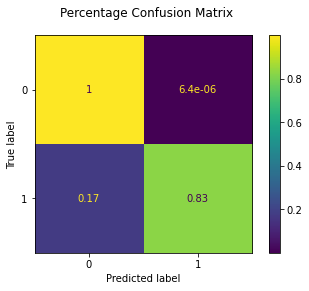

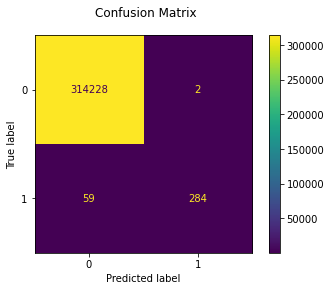

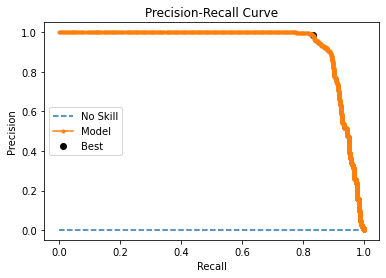

Model PR AUC: 0.9369843144519565
Best Threshold=0.427354, F-Score=0.904


In [7]:
plot_metrics(y_test, y_pred_XGBBoost, y_pred_XGBBoost_prob, Y)

### Finding the best parameters

For this second part of the xGboost model, we are going to modify the model in order to improve the F2 score of our model by searching for the best and most significant parameters of our model.

In [8]:
from sklearn.model_selection import GridSearchCV
param_grid = {"subsample":[0.5, 0.75, 1], "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12], "min_child_weight":[1,5,15], "learning_rate":[0.3, 0.1, 0.03],
              "n_estimators":[100]}

model = XGBClassifier()
best_XGBoost = RandomizedSearchCV(model,param_grid,cv=3,scoring="f1_macro") #
best_XGBoost.fit(x_train_scaled, y_train)
print(best_XGBoost.best_params_)

{'subsample': 0.75, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1}


In [9]:
y_pred_XGBBoost = best_XGBoost.predict(x_test_scaled)
y_pred_XGBBoost_prob = best_XGBoost.predict_proba(x_test_scaled)

Metrics obtained after selecting the best parameters


F2 Score: 0.9281577285541565

R2 Score: 0.8102887719706156

Accuracy Score: 0.99979337069615

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       0.98      0.83      0.90       343

    accuracy                           1.00    314573
   macro avg       0.99      0.92      0.95    314573
weighted avg       1.00      1.00      1.00    314573



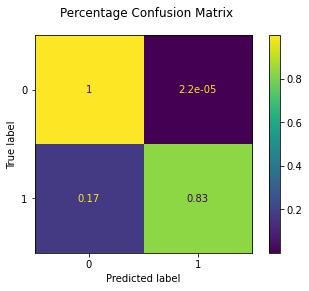

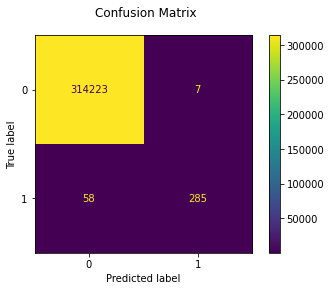

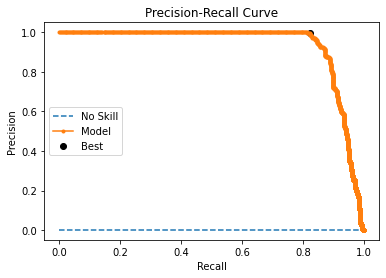

Model PR AUC: 0.933084779336112
Best Threshold=0.630126, F-Score=0.901


In [10]:
plot_metrics(y_test, y_pred_XGBBoost, y_pred_XGBBoost_prob, Y)

After making the best parameters for the model, we managed to improve the model in the F2 score, the improvement is not very significant since the model is already good in itself, but it serves to improve, so we keep this one.

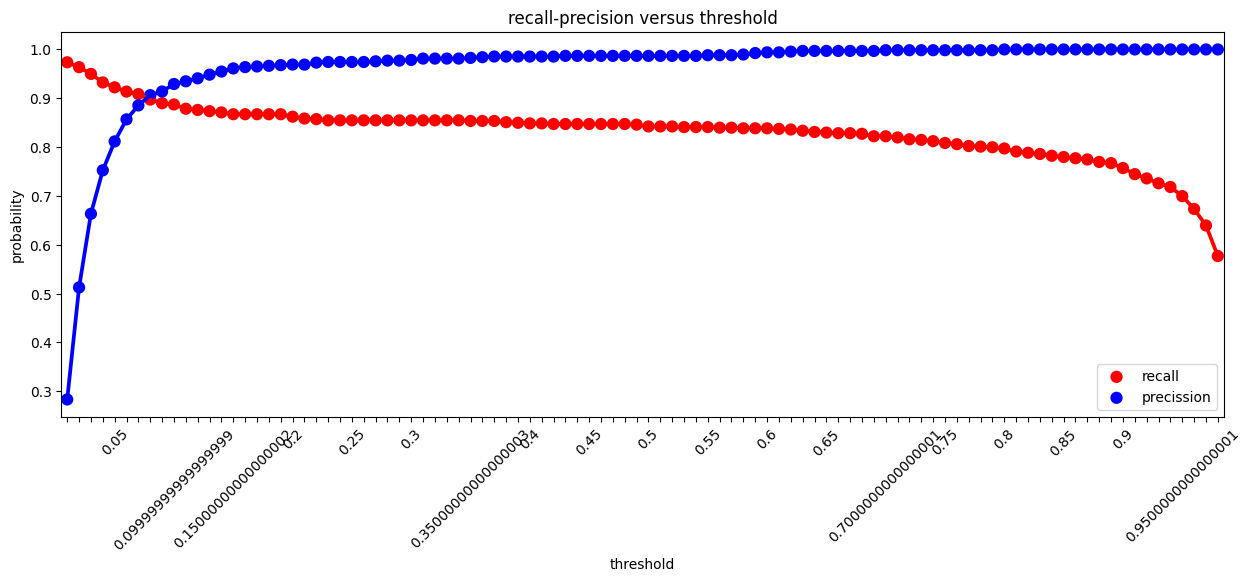

In [11]:
plot_threshold(best_XGBoost, x_train_scaled, x_test_scaled, y_train, y_test)

We plot the graph to find the optimal threshold where the precision and recall curves intersect. We find that the optimal threshold is at 0.07 approximately, which is where both graphs intersect. 

We study how the confusion matrix is shared by changing the Treshold.

Text(0.5, 0.98, 'Impact of threshold adjustment on the error matrix')

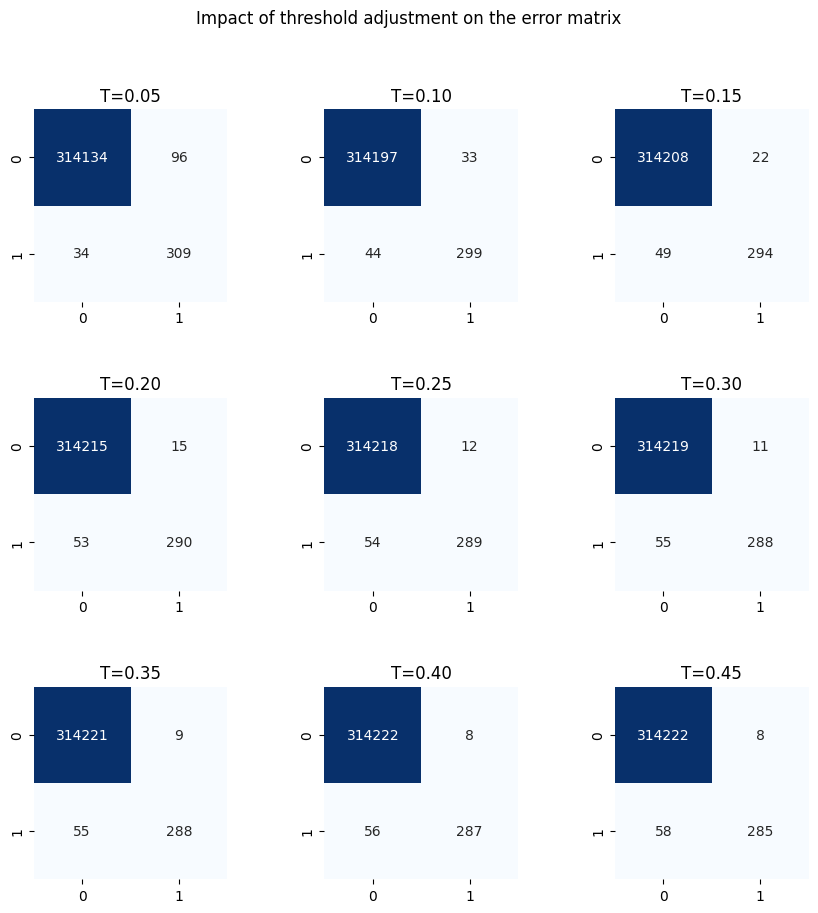

In [26]:
y_pred = best_XGBoost.predict_proba(x_test_scaled)[:,1]

fig, axes = plt.subplots(3,3, figsize=(10,10))

for t, ax in enumerate(axes.flat):
    threshold = (t+1)/20

    y_pred_int = (y_pred > threshold).astype(int)
    c_matrix = confusion_matrix(y_test, y_pred_int)
    sns.heatmap(c_matrix, annot=True, cmap="Blues", fmt="d", ax=ax, cbar=False)
    ax.title.set_text("T=%.2f" % threshold)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Impact of threshold adjustment on the error matrix")

Looking at the plot above, we can indeed confirm that T=0.05 gives the best interpretation. The false negatives are lower. Increasing the threshold leads missing more fraudulent transactions.

We now turn to the explanability of the model.

In [13]:
# Modelo con los parámetros encontradso
best_XGBoost.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

The variables in the following graph will appear in order of more or less significance in the model.

In [14]:
explainer = shap.TreeExplainer(best_XGBoost.best_estimator_)
shap_values = explainer.shap_values(x_test_scaled)

If we want to see the relationship of all the variables to the model, and the impact they have, then we can use the Summary Plot. With this plot we see the SHAP value of each feature in the training set.

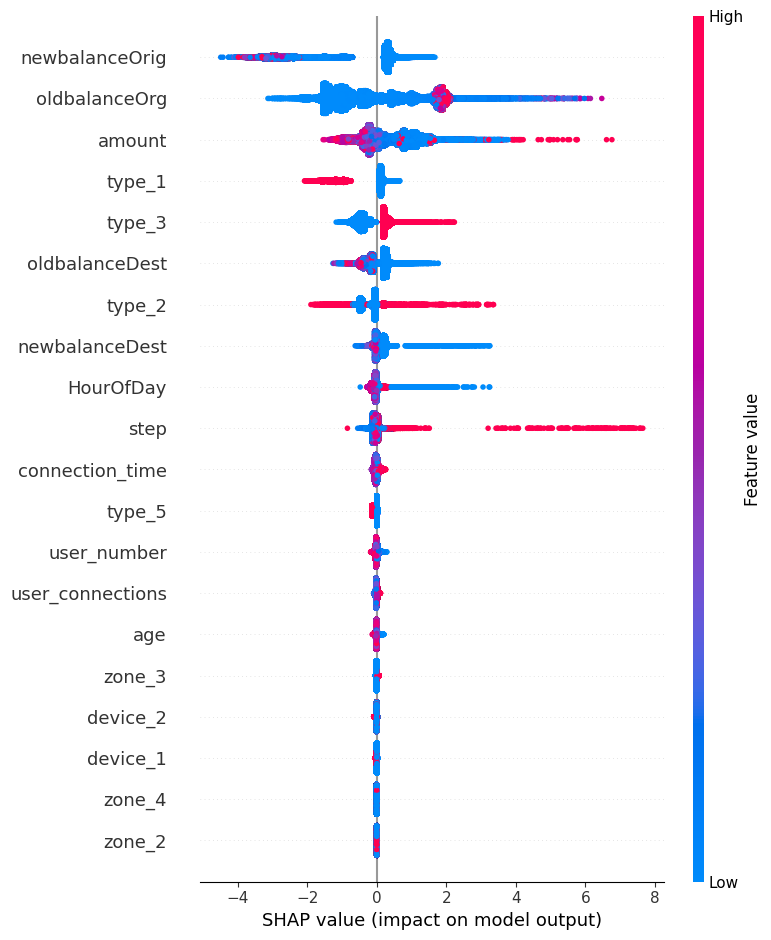

In [15]:
shap.summary_plot(shap_values, x_test_scaled)

We can see in the image that the variable 'OldbalanceOrg' has a high negative effect, which makes the prediction lower its value with respect to the base value. The value that appears equal to the variable is the value of the parameter in this example. We can also see that variables such as 'newbalanceOrg' and 'type 1' have a positive effect, which makes the prediction have a higher value. However, the values in blue have a higher weight in this case than the values in red, which is why the f(x) value is lower than the base value of the model.


<img src='../images/Type.png'>

As we have seen in the EDA above, the variable type is distributed as shown in the image above.

Another way to see the importance of variables with Summary Plot is as follows:

In [23]:
# Using a random sample of the dataframe for better time computation
X_sampled = x_test_scaled.sample(100, random_state=seed)

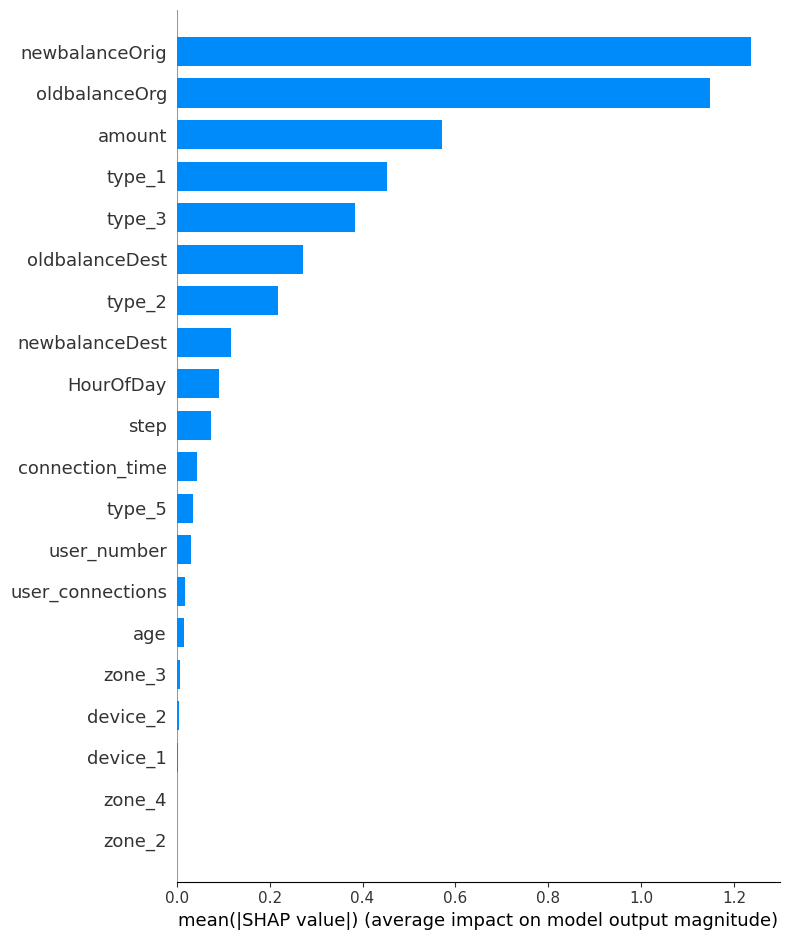

In [22]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")

In [16]:
shap.initjs()

In [17]:
# Using a random sample of the dataframe for better time computation
X_sampled = x_test_scaled.sample(100, random_state=seed)

In [18]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(best_XGBoost.best_estimator_)
shap_values = explainer.shap_values(X_sampled)

In [19]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:], link='logit')

The parameters that are in red are the ones that make the prediction have a higher value, while the parameters in blue make the prediction have a lower value.

It can be seen in the image how the variable *newbalanceOrig* has a negative effect, which causes the prediction to lower its value. While *oldbalanceOrg* and *amount* has a positive effect.

If we want to see the importance of these features in the predictions of the whole dataset, we can visualize it as follows:

In [20]:
# visualize the testing set predictions
shap.force_plot(explainer.expected_value, shap_values, x_test_scaled, link='logit')

We see in the image above the predictions for the whole dataset X, where each prediction is vertically, i.e. for each row of X we see the visualization of the weight of the features on the Y-axis, and these are stacked horizontally on the X-axis. 
It is worth noting that this visualization is interactive on the notebook, where you can change both what you see at the top of the image (sample order by similarity) and on the left side (f(x)).

The interpretability of Machine Learning models is a very important aspect for organizations where more and more of these models are put into production as a "black box" without knowing if their results can be explained.

In this notebook we have used SHAP to solve this difficulty and to be one step closer to the explainability of machine learning models. This library allows us to see if the input parameters of the model make sense and how important are these variables to predict the model's outcome. SHAP allows us to analyze different types of models in different scenarios which makes it a very useful tool for putting large scale models into production.